<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_data_preprocessing_with_70_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


## Data Preprocessing

In [7]:
diabetes_train = pickle.load(open("diabetes_train.pkl", "rb"))

### Handling categorical values

In [8]:
diab_train_df = diabetes_train.loc[:, diabetes_train.columns != 'diabetes_mellitus']
diab_train_target = diabetes_train['diabetes_mellitus']
diab_train_df = diab_train_df.drop(columns='Unnamed: 0')

In [9]:
diab_train_df.columns

Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source',
       ...
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min',
       'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=179)

In [10]:
# features that are categorical

for cols in diab_train_df.columns:
    if(diab_train_df[cols].dtype == object):
        print("{0} : {1}".format(cols, diab_train_df[cols].dtype))

ethnicity : object
gender : object
hospital_admit_source : object
icu_admit_source : object
icu_stay_type : object
icu_type : object


In [ ]:
diab_train_df[['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_type']]

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type
0,Caucasian,M,Floor,Floor,CTICU
1,Caucasian,F,Floor,Floor,Med-Surg ICU
2,Caucasian,F,Emergency Department,Accident & Emergency,Med-Surg ICU
3,Caucasian,F,Operating Room,Operating Room / Recovery,CTICU
4,Caucasian,M,NaN,Accident & Emergency,Med-Surg ICU
...,...,...,...,...,...
130152,Caucasian,M,Emergency Department,Accident & Emergency,Cardiac ICU
130153,Caucasian,F,Direct Admit,Accident & Emergency,MICU
130154,African American,M,Emergency Department,Accident & Emergency,Cardiac ICU
130155,Caucasian,M,Emergency Department,Accident & Emergency,Med-Surg ICU


In [27]:
# unique values in the categorical columns

obj_cols = {'ethnicity','gender','hospital_admit_source','icu_admit_source','icu_type', 'icu_stay_type'}
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))
    print()

icu_admit_source: ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' 'Unknown/Other(preprocessed)']

hospital_admit_source: ['Floor' 'Emergency Department' 'Operating Room'
 'Unknown/Other(preprocessed)' 'Direct Admit' 'Other Hospital' 'Other ICU'
 'ICU to SDU' 'Recovery Room' 'Chest Pain Center' 'Step-Down Unit (SDU)'
 'Acute Care/Floor' 'PACU' 'Observation' 'ICU' 'Other']

ethnicity: ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']

icu_stay_type: ['admit' 'readmit' 'transfer']

icu_type: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']

gender: ['M' 'F']



#### Handling missing values for 'gender':



In [30]:
diab_train_df[['gender']].head()

,gender
0,M
1,F
2,F
3,F
4,M


In [31]:
diab_train_df['gender'].isnull().sum()

0

In [32]:
diab_train_df['gender'] = diab_train_df['gender'].fillna(method='ffill')

In [33]:
diab_train_df['gender'].isnull().sum()

0

#### Handling missing values for 'ethnicity':



In [34]:
diab_train_df['ethnicity'].isnull().sum()

1587

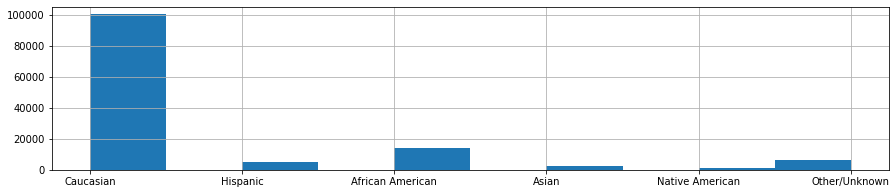

In [35]:
diab_train_df['ethnicity'].hist(figsize=(15,3))

In [36]:
diab_train_df['ethnicity'].replace(np.nan, "Unknown/Other(preprocessed)", inplace=True)
diab_train_df['ethnicity'].isnull().sum()

0

#### Handling missing values for 'icu_type':



In [37]:
diab_train_df['icu_type'].isnull().sum()

0

#### Handling missing values for 'icu_admit_source':



In [38]:
diab_train_df['icu_admit_source'].isnull().sum()

0

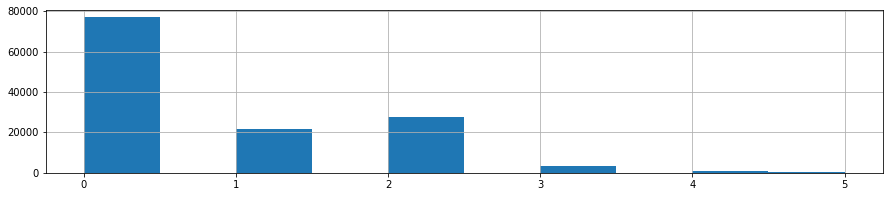

In [39]:
diab_train_df['icu_admit_source'].hist(figsize=(15,3))

In [40]:
diab_train_df['icu_admit_source'].replace(np.nan, "Unknown/Other(preprocessed)", inplace=True)
diab_train_df['icu_admit_source'].isnull().sum()

0

#### Handling missing values for 'hospital_admit_source':



In [41]:
diab_train_df['hospital_admit_source'].isnull().sum()

0

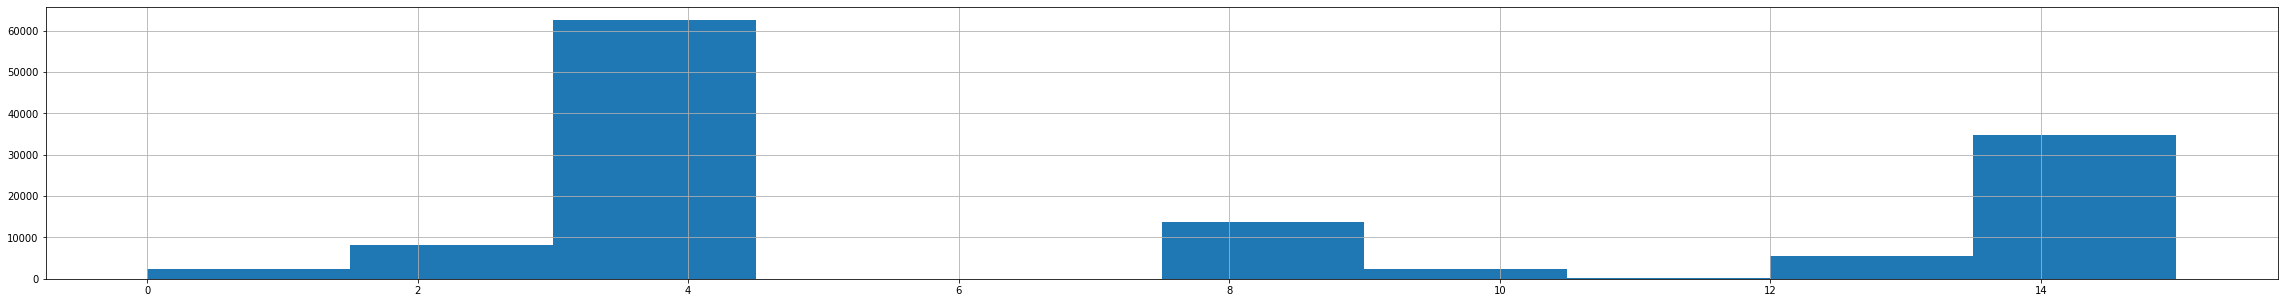

In [42]:
diab_train_df['hospital_admit_source'].hist(figsize=(40,5))

In [43]:
diab_train_df['hospital_admit_source'].replace(np.nan, "Unknown/Other(preprocessed)", inplace=True)
diab_train_df['hospital_admit_source'].isnull().sum()

0

#### Handling missing values for 'icu_stay_type':



In [44]:
diab_train_df['icu_stay_type'].isnull().sum()

0

In [45]:
for col in obj_cols:
    print("{0}: {1}\n".format(col, diab_train_df[col].unique()))

icu_admit_source: [1 0 2 3 4 5]

hospital_admit_source: [ 4  3  8 15  2 10 11  6 13  1 14  0 12  7  5  9]

ethnicity: ['Caucasian' 'Unknown/Other(preprocessed)' 'Hispanic' 'African American'
 'Asian' 'Native American' 'Other/Unknown']

icu_stay_type: ['admit' 'readmit' 'transfer']

icu_type: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']

gender: ['M' 'F']



### Encoding categorical features:

In [46]:
enc = LabelEncoder()
for cols in obj_cols:
    diab_train_df[cols] = enc.fit_transform(diab_train_df[cols])    

In [47]:
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))

icu_admit_source: [1 0 2 3 4 5]
hospital_admit_source: [ 4  3  8 15  2 10 11  6 13  1 14  0 12  7  5  9]
ethnicity: [2 6 3 0 1 4 5]
icu_stay_type: [0 1 2]
icu_type: [2 5 0 6 4 7 3 1]
gender: [1 0]


In [ ]:
#https://www.kaggle.com/danofer/apache-iiij-icu-diagnosis-codes?select=icu-apache-codes-ANZICS.csv
#apache2 and apache3 data is present in this dataset, there is redundant information
#Action: drop the apache2 data, apache3 is more fine grained according to below paper:
#reference- https://pubmed.ncbi.nlm.nih.gov/11579607/#:~:text=Results%3A%20Both%20systems%20showed%20a,0.6856%3B%20p%20%3C%200.05).
diab_train_df['apache_3j_diagnosis'] = (diab_train_df.apache_3j_diagnosis).fillna(0).astype(int)
if "apache_2_diagnosis" in diab_train_df.columns:
  diab_train_df = diab_train_df.drop("apache_2_diagnosis",axis=1)

#we can drop readmission status
if "readmission_status" in diab_train_df.columns:
  diab_train_df = diab_train_df.drop("readmission_status",axis=1)

### Handling null values for 'age'

In [ ]:
#for missing age (age=0), replace them with mean age
diab_train_df['age']=diab_train_df['age'].astype(str).astype(float)
val = diab_train_df['age'].mean()
diab_train_df['age'] = diab_train_df['age'].replace(0, val)
diab_train_df["age"] = diab_train_df["age"].fillna(val)
diab_train_df["age"].isnull().sum()


0

# Drop cols with null values

In [ ]:
diab_train_reduced = diab_train_df.copy(deep=True)

In [ ]:
def missing_percentage(df):
    missing_count=df.isnull().sum()
    missing_df = (pd.concat([missing_count.rename('Missing count'),missing_count.div(len(df))
                .rename('Missing percent')],axis = 1))
    missing_df.style.background_gradient(cmap="Blues")

    return missing_df

In [ ]:
missing_df = missing_percentage(diab_train_df)
missing_df

,Missing count,Missing percent
encounter_id,0,0.000000
hospital_id,0,0.000000
age,4988,0.038323
bmi,4490,0.034497
elective_surgery,0,0.000000
...,...,...
hepatic_failure,0,0.000000
immunosuppression,0,0.000000
leukemia,0,0.000000
lymphoma,0,0.000000


In [ ]:
cols_above_threshold = missing_df[missing_df['Missing percent']>0.7]

In [ ]:
cols_above_threshold

,Missing count,Missing percent
fio2_apache,99720,0.766152
paco2_apache,99720,0.766152
paco2_for_ph_apache,99720,0.766152
pao2_apache,99720,0.766152
ph_apache,99720,0.766152
d1_diasbp_invasive_max,95068,0.730410
d1_diasbp_invasive_min,95068,0.730410
d1_mbp_invasive_max,94868,0.728874
d1_mbp_invasive_min,94868,0.728874
d1_sysbp_invasive_max,95038,0.730180


In [ ]:
diab_train_reduced.drop(columns=cols_above_threshold.index, inplace=True)

### Dropping columns that don't have an effect on the target variable

In [ ]:
columns_to_drop = ['hospital_id','elective_surgery','icu_id','icu_stay_type','icu_type','aids','cirrhosis','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']

In [ ]:
diab_train_reduced.drop(columns=columns_to_drop, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(diab_train_reduced, diab_train_target, test_size=0.2, random_state=42)

In [ ]:
pickle.dump(train_X, open("diabetes_train_X_70.pkl", "wb"))
pickle.dump(train_y, open("diabetes_train_y_70.pkl", "wb"))
pickle.dump(test_y, open("diabetes_test_y_70.pkl", "wb"))


In [ ]:
train_y

115201    1
5903      0
68265     0
109489    0
14762     0
         ..
128106    0
103694    1
860       0
15795     1
121958    0
Name: diabetes_mellitus, Length: 104125, dtype: int64

In [ ]:
train_X

,encounter_id,age,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,albumin_apache,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,...,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min
115201,167434,60.000000,40.234881,2,1,185.4,8,2,0.096528,138.3,2.4,1208,1,0,0.3,94.0,7.07,4.0,6.0,0.0,5.0,51.0,58.0,21.8,0,59.0,12.0,134.0,35.0,4690.6560,0,16.20,90.0,44.0,90.0,44.0,71.0,60.0,96.0,60.0,...,35.0,35.0,2.6,2.4,0.3,0.3,94.0,89.0,7.8,7.5,7.07,6.08,171.0,52.0,18.0,16.0,7.8,6.8,24.2,21.8,1.00,1.00,325.0,309.0,5.0,4.1,138.0,134.0,16.20,12.90,106.0,52.0,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
5903,236683,73.000000,30.100790,2,1,175.3,8,2,0.000694,92.5,NaN,1205,1,0,NaN,21.0,0.91,4.0,6.0,0.0,5.0,200.0,120.0,39.6,0,122.0,43.0,138.0,36.4,NaN,0,15.10,98.0,57.0,98.0,57.0,127.0,86.0,122.0,77.0,...,36.7,36.7,NaN,NaN,NaN,NaN,21.0,20.0,8.7,8.5,0.98,0.91,200.0,114.0,24.0,24.0,13.9,13.1,42.1,39.6,NaN,NaN,120.0,112.0,4.4,3.9,138.0,138.0,15.10,14.30,115.0,115.0,NaN,NaN,39.0,39.0,7.380,7.380,68.0,68.0
68265,148607,70.000000,15.500031,2,1,177.8,15,1,0.604861,49.0,NaN,703,0,0,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,104.0,NaN,0,120.0,60.0,NaN,36.2,5879.7792,0,NaN,96.0,76.0,96.0,76.0,96.0,62.0,110.0,82.0,...,NaN,NaN,3.2,3.2,0.6,0.6,5.0,5.0,8.6,8.6,0.48,0.48,107.0,104.0,NaN,NaN,12.1,12.1,36.0,36.0,NaN,NaN,107.0,107.0,3.5,3.5,139.0,139.0,10.90,10.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109489,170512,68.000000,28.069727,5,1,182.9,15,0,0.188889,93.9,NaN,104,0,0,NaN,20.0,1.55,4.0,6.0,0.0,5.0,105.0,139.0,33.9,0,189.0,35.0,132.0,36.3,5067.6192,0,7.60,94.0,72.0,94.0,72.0,137.0,70.0,184.0,86.0,...,36.3,36.3,NaN,NaN,NaN,NaN,20.0,20.0,8.6,8.6,1.55,1.55,105.0,105.0,27.0,27.0,11.5,11.5,33.9,33.9,NaN,NaN,116.0,116.0,3.4,2.8,132.0,132.0,7.60,7.60,NaN,NaN,NaN,NaN,43.0,36.0,7.500,7.450,138.0,78.0
14762,253558,51.000000,30.722940,3,0,167.6,3,0,0.059722,86.3,NaN,201,0,0,NaN,27.0,0.68,2.0,5.0,0.0,3.0,93.0,139.0,29.7,1,46.0,33.0,136.0,36.1,973.7280,1,27.41,67.0,40.0,67.0,40.0,128.0,96.0,78.0,51.0,...,36.7,36.7,NaN,NaN,NaN,NaN,27.0,27.0,9.2,9.2,0.68,0.68,118.0,93.0,26.0,26.0,9.7,9.7,29.7,29.7,NaN,NaN,347.0,347.0,4.7,4.7,136.0,136.0,27.41,27.41,NaN,NaN,NaN,NaN,51.9,48.7,7.374,7.353,57.4,57.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,171618,20.000000,25.313660,0,0,165.1,2,0,0.000000,69.0,NaN,409,0,0,NaN,7.0,0.68,4.0,6.0,0.0,5.0,119.0,103.0,36.0,0,58.0,36.0,135.0,36.6,1079.2224,0,5.20,80.0,51.0,80.0,51.0,86.0,49.0,93.0,65.0,...,36.9,36.9,NaN,NaN,NaN,NaN,7.0,7.0,9.7,9.7,0.68,0.68,119.0,119.0,25.0,25.0,11.3,11.3,36.0,36.0,1.12,1.12,319.0,319.0,5.1,5.1,135.0,135.0,5.20,5.20,NaN,NaN,1.12,1.12,34.7,34.7,7.422,7.422,300.0,300.0
103694,234427,61.995103,17.566702,2,0,152.4,3,0,0.284028,40.8,1.9,501,0,0

In [ ]:
diab_train_reduced.info

<bound method DataFrame.info of         encounter_id   age  ...  d1_arterial_po2_max  d1_arterial_po2_min
0             214826  68.0  ...                  NaN                  NaN
1             246060  77.0  ...                 51.0                 51.0
2             276985  25.0  ...                  NaN                  NaN
3             262220  81.0  ...                337.0                102.0
4             201746  19.0  ...                  NaN                  NaN
...              ...   ...  ...                  ...                  ...
130152        164758  50.0  ...                  NaN                  NaN
130153        197653  79.0  ...                  NaN                  NaN
130154        219719  73.0  ...                163.0                 80.0
130155        222562  81.0  ...                  NaN                  NaN
130156        157942  35.0  ...                  NaN                  NaN

[130157 rows x 110 columns]>

In [ ]:
pickle.dump(diab_train_reduced, open("diab_train_reduced_70.pkl", "wb"))


## Imputing null values for non-categorical features

In [ ]:
trainX_copy_wo_age = pd.DataFrame(train_X) 
trainX_copy_wo_age = trainX_copy_wo_age.drop(columns='age')
imputer = KNNImputer(n_neighbors=30)
%time
KNN_imputed_trainX_wo_age = imputer.fit_transform(trainX_copy_wo_age)


pickle.dump(KNN_imputed_trainX_wo_age, open("KNN_imputed_trainX_wo_age_70.pkl", "wb"))
KNN_imputed_trainX_wo_age_pkl = pickle.load(open("KNN_imputed_trainX_wo_age_70.pkl", "rb"))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [ ]:
KNN_imputed_trainX_wo_age_df = pd.DataFrame(KNN_imputed_trainX_wo_age_pkl, columns=trainX_copy_wo_age.columns, index=trainX_copy_wo_age.index)

In [ ]:
KNN_imputed_trainX_wo_age_df

,encounter_id,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,albumin_apache,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,...,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min
115201,167434.0,40.234881,2.0,1.0,185.4,8.0,2.0,0.096528,138.3,2.400000,1208.0,1.0,0.0,0.300000,94.000000,7.070000,4.0,6.0,0.0,5.0,51.000000,58.0,21.800000,0.0,59.0,12.0,134.0,35.0,4690.65600,0.0,16.200000,90.0,44.0,90.0,44.0,71.0,60.0,96.0,60.0,96.0,...,35.000000,35.000000,2.600000,2.400000,0.300000,0.300000,94.0,89.0,7.8,7.5,7.07,6.08,171.0,52.0,18.0,16.0,7.8,6.8,24.2,21.8,1.000000,1.000000,325.0,309.0,5.0,4.1,138.0,134.0,16.20,12.90,106.000000,52.000000,1.000000,1.000000,46.516667,38.010000,7.380233,7.310033,146.210000,92.786667
5903,236683.0,30.100790,2.0,1.0,175.3,8.0,2.0,0.000694,92.5,2.803333,1205.0,1.0,0.0,2.147667,21.000000,0.910000,4.0,6.0,0.0,5.0,200.000000,120.0,39.600000,0.0,122.0,43.0,138.0,36.4,1604.41632,0.0,15.100000,98.0,57.0,98.0,57.0,127.0,86.0,122.0,77.0,122.0,...,36.700000,36.700000,2.833333,2.793333,2.107667,2.090333,21.0,20.0,8.7,8.5,0.98,0.91,200.0,114.0,24.0,24.0,13.9,13.1,42.1,39.6,1.281667,1.223667,120.0,112.0,4.4,3.9,138.0,138.0,15.10,14.30,115.000000,115.000000,1.281667,1.223667,39.000000,39.000000,7.380000,7.380000,68.000000,68.000000
68265,148607.0,15.500031,2.0,1.0,177.8,15.0,1.0,0.604861,49.0,2.933333,703.0,0.0,0.0,0.984667,25.186667,1.442667,4.0,6.0,0.0,5.0,121.333333,104.0,32.946667,0.0,120.0,60.0,138.7,36.2,5879.77920,0.0,12.029333,96.0,76.0,96.0,76.0,96.0,62.0,110.0,82.0,110.0,...,37.247333,36.957333,3.200000,3.200000,0.600000,0.600000,5.0,5.0,8.6,8.6,0.48,0.48,107.0,104.0,23.0,22.6,12.1,12.1,36.0,36.0,1.705667,1.509000,107.0,107.0,3.5,3.5,139.0,139.0,10.90,10.90,127.366667,121.766667,1.705667,1.509000,38.873333,33.613333,7.386300,7.316733,148.576667,96.943333
109489,170512.0,28.069727,5.0,1.0,182.9,15.0,0.0,0.188889,93.9,2.983333,104.0,0.0,0.0,1.103333,20.000000,1.550000,4.0,6.0,0.0,5.0,105.000000,139.0,33.900000,0.0,189.0,35.0,132.0,36.3,5067.61920,0.0,7.600000,94.0,72.0,94.0,72.0,137.0,70.0,184.0,86.0,181.0,...,36.300000,36.300000,2.953333,2.943333,1.110000,1.063333,20.0,20.0,8.6,8.6,1.55,1.55,105.0,105.0,27.0,27.0,11.5,11.5,33.9,33.9,1.361000,1.327667,116.0,116.0,3.4,2.8,132.0,132.0,7.60,7.60,172.433333,168.800000,1.361000,1.327667,43.000000,36.000000,7.500000,7.450000,138.000000,78.000000
14762,253558.0,30.722940,3.0,0.0,167.6,3.0,0.0,0.059722,86.3,2.890000,201.0,0.0,0.0,0.703333,27.000000,0.680000,2.0,5.0,0.0,3.0,93.000000,139.0,29.700000,1.0,46.0,33.0,136.0,36.1,973.72800,1.0,27.410000,67.0,40.0,67.0,40.0,128.0,96.0,78.0,51.0,78.0,...,36.700000,36.700000,2.953333,2.923333,0.679667,0.663000,27.0,27.0,9.2,9.2,0.68,0.68,118.0,93.0,26.0,26.0,9.7,9.7,29.7,29.7,1.361667,1.338000,347.0,347.0,4.7,4.7,136.0,136.0,27.41,27.41,141.466667,140.300000,1.361667,1.338000,51.900000,48.700000,7.374000,7.353000,57.400000,57.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
# add age back to df
KNN_imputed_trainX = KNN_imputed_trainX_wo_age_df.copy(deep=True)
KNN_imputed_trainX['age']= train_X['age'].values
print(KNN_imputed_trainX['age'].isnull().sum())

# drop encounter_id as it's not needed
if('encounter_id' in KNN_imputed_trainX.columns):
  KNN_imputed_trainX = KNN_imputed_trainX.drop(columns=['encounter_id'])

if('encounter_id' in test_X.columns):
  test_X = test_X.drop(columns=['encounter_id'])
pickle.dump(KNN_imputed_trainX, open("KNN_imputed_trainX_70.pkl", "wb"))

KNN_imputed_trainX


0


,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,albumin_apache,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,...,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,age
115201,40.234881,2.0,1.0,185.4,8.0,2.0,0.096528,138.3,2.400000,1208.0,1.0,0.0,0.300000,94.000000,7.070000,4.0,6.0,0.0,5.0,51.000000,58.0,21.800000,0.0,59.0,12.0,134.0,35.0,4690.65600,0.0,16.200000,90.0,44.0,90.0,44.0,71.0,60.0,96.0,60.0,96.0,60.0,...,35.000000,2.600000,2.400000,0.300000,0.300000,94.0,89.0,7.8,7.5,7.07,6.08,171.0,52.0,18.0,16.0,7.8,6.8,24.2,21.8,1.000000,1.000000,325.0,309.0,5.0,4.1,138.0,134.0,16.20,12.90,106.000000,52.000000,1.000000,1.000000,46.516667,38.010000,7.380233,7.310033,146.210000,92.786667,60.000000
5903,30.100790,2.0,1.0,175.3,8.0,2.0,0.000694,92.5,2.803333,1205.0,1.0,0.0,2.147667,21.000000,0.910000,4.0,6.0,0.0,5.0,200.000000,120.0,39.600000,0.0,122.0,43.0,138.0,36.4,1604.41632,0.0,15.100000,98.0,57.0,98.0,57.0,127.0,86.0,122.0,77.0,122.0,77.0,...,36.700000,2.833333,2.793333,2.107667,2.090333,21.0,20.0,8.7,8.5,0.98,0.91,200.0,114.0,24.0,24.0,13.9,13.1,42.1,39.6,1.281667,1.223667,120.0,112.0,4.4,3.9,138.0,138.0,15.10,14.30,115.000000,115.000000,1.281667,1.223667,39.000000,39.000000,7.380000,7.380000,68.000000,68.000000,73.000000
68265,15.500031,2.0,1.0,177.8,15.0,1.0,0.604861,49.0,2.933333,703.0,0.0,0.0,0.984667,25.186667,1.442667,4.0,6.0,0.0,5.0,121.333333,104.0,32.946667,0.0,120.0,60.0,138.7,36.2,5879.77920,0.0,12.029333,96.0,76.0,96.0,76.0,96.0,62.0,110.0,82.0,110.0,82.0,...,36.957333,3.200000,3.200000,0.600000,0.600000,5.0,5.0,8.6,8.6,0.48,0.48,107.0,104.0,23.0,22.6,12.1,12.1,36.0,36.0,1.705667,1.509000,107.0,107.0,3.5,3.5,139.0,139.0,10.90,10.90,127.366667,121.766667,1.705667,1.509000,38.873333,33.613333,7.386300,7.316733,148.576667,96.943333,70.000000
109489,28.069727,5.0,1.0,182.9,15.0,0.0,0.188889,93.9,2.983333,104.0,0.0,0.0,1.103333,20.000000,1.550000,4.0,6.0,0.0,5.0,105.000000,139.0,33.900000,0.0,189.0,35.0,132.0,36.3,5067.61920,0.0,7.600000,94.0,72.0,94.0,72.0,137.0,70.0,184.0,86.0,181.0,86.0,...,36.300000,2.953333,2.943333,1.110000,1.063333,20.0,20.0,8.6,8.6,1.55,1.55,105.0,105.0,27.0,27.0,11.5,11.5,33.9,33.9,1.361000,1.327667,116.0,116.0,3.4,2.8,132.0,132.0,7.60,7.60,172.433333,168.800000,1.361000,1.327667,43.000000,36.000000,7.500000,7.450000,138.000000,78.000000,68.000000
14762,30.722940,3.0,0.0,167.6,3.0,0.0,0.059722,86.3,2.890000,201.0,0.0,0.0,0.703333,27.000000,0.680000,2.0,5.0,0.0,3.0,93.000000,139.0,29.700000,1.0,46.0,33.0,136.0,36.1,973.72800,1.0,27.410000,67.0,40.0,67.0,40.0,128.0,96.0,78.0,51.0,78.0,51.0,...,36.700000,2.953333,2.923333,0.679667,0.663000,27.0,27.0,9.2,9.2,0.68,0.68,118.0,93.0,26.0,26.0,9.7,9.7,29.7,29.7,1.361667,1.338000,347.0,347.0,4.7,4.7,136.0,136.0,27.41,27.41,141.466667,140.300000,1.361667,1.338000,51.900000,48.700000,7.374000,7.353000,57.400000,57.100000,51.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
pickle.dump(test_X, open("diabetes_test_X_70.pkl", "wb")) # after dropping encounter ID

Imputing test set values

In [ ]:
imputer = KNNImputer(n_neighbors=30)
KNN_imputed_testX = imputer.fit_transform(test_X)

pickle.dump(KNN_imputed_testX, open("KNN_imputed_testX_70.pkl", "wb"))
KNN_imputed_testX_pkl = pickle.load(open("KNN_imputed_testX_70.pkl", "rb"))

In [ ]:
KNN_imputed_testX_df = pd.DataFrame(KNN_imputed_testX_pkl, columns=test_X.columns, index=test_X.index)

pickle.dump(KNN_imputed_testX_df, open("KNN_imputed_testX_df_70.pkl", "wb"))

In [ ]:
KNN_imputed_testX_df

,age,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,albumin_apache,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,...,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min
71328,61.995103,28.178382,2.0,0.0,157.5,15.0,0.0,0.338889,69.900000,2.680000,502.0,0.0,0.0,1.043333,41.00,2.220000,4.0,6.0,0.0,4.0,141.0,119.0,33.143333,0.0,62.0,47.0,137.000000,36.7,2242.92384,0.0,15.796000,60.0,51.0,60.0,51.0,104.0,82.0,86.0,64.0,86.0,...,36.700000,36.700000,2.600000,2.600000,0.700000,0.700000,41.000000,36.000000,8.000000,7.90,2.220000,1.730000,141.000000,123.000000,22.406667,21.700000,12.200000,12.200000,37.000000,37.000000,1.999200,1.881567,87.000000,87.000000,4.000000,3.400000,137.000000,137.000000,40.300000,40.300000,141.000000,141.000000,1.999200,1.881567,26.800000,26.800000,7.320000,7.320000,72.000000,72.000000
107114,74.000000,21.593341,1.0,0.0,145.0,15.0,0.0,0.005556,45.400000,3.303333,704.0,0.0,0.0,0.910000,13.00,1.040000,4.0,6.0,0.0,5.0,100.0,49.0,37.556667,0.0,142.0,12.0,117.000000,36.8,3114.20160,0.0,10.042667,112.0,62.0,112.0,62.0,68.0,50.0,134.0,73.0,134.0,...,36.600000,36.600000,3.333333,3.276667,0.916667,0.913333,13.000000,13.000000,8.200000,8.20,1.040000,1.040000,100.000000,100.000000,24.166667,23.333333,13.103333,12.936667,38.873333,38.333333,1.504000,1.417333,207.966667,204.433333,4.100000,4.100000,130.000000,117.000000,10.154000,9.719667,98.900000,95.533333,1.504000,1.417333,41.226667,39.740000,7.397367,7.379362,153.208833,114.009733
33650,62.000000,30.957006,2.0,0.0,152.4,4.0,1.0,2.962500,71.900000,2.800000,212.0,0.0,0.0,0.400000,16.00,0.630000,2.0,6.0,0.0,1.0,165.0,45.0,31.300000,1.0,44.0,38.0,138.000000,36.6,4387.99680,1.0,13.900000,100.0,31.0,100.0,31.0,109.0,46.0,118.0,61.0,118.0,...,36.600000,36.600000,2.800000,2.600000,0.600000,0.400000,16.000000,15.000000,7.700000,6.90,0.740000,0.630000,165.000000,116.000000,25.000000,24.000000,10.800000,10.100000,31.300000,29.100000,1.839667,1.743333,161.000000,137.000000,3.700000,3.500000,138.000000,135.000000,13.900000,10.600000,134.133333,131.600000,1.839667,1.743333,40.000000,34.000000,7.470000,7.360000,136.000000,68.000000
119933,77.000000,20.338409,2.0,0.0,154.9,3.0,0.0,0.074306,48.800000,3.300000,102.0,0.0,0.0,0.300000,19.00,0.300000,1.0,1.0,0.0,1.0,98.0,107.0,34.276667,1.0,135.0,4.0,143.000000,36.1,1154.47680,1.0,10.615000,72.0,35.0,72.0,35.0,101.0,72.0,126.0,48.0,126.0,...,36.100000,36.100000,3.600000,3.100000,0.300000,0.300000,19.000000,14.000000,9.400000,8.80,0.500000,0.300000,158.000000,98.000000,32.000000,26.000000,11.900000,11.900000,37.200000,37.200000,1.592333,1.478667,242.000000,242.000000,3.900000,3.600000,145.000000,139.000000,10.000000,10.000000,122.466667,121.333333,1.592333,1.478667,45.000000,45.000000,7.450000,7.450000,57.000000,57.000000
3395,51.000000,26.465564,2.0,1.0,172.7,2.0,0.0,0.003472,78.443667,3.400000,408.0,0.0,0.0,1.000000,23.00,0.960000,3.0,5.0,0.0,4.0,89.0,103.0,37.300000,0.0,75.0,43.0,145.000000,37.3,1899.93

## Logistic regression

In [ ]:
#standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(KNN_imputed_trainX)
scaled_test_df = scaler.fit_transform(KNN_imputed_testX_df)

0.7377842655193608


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


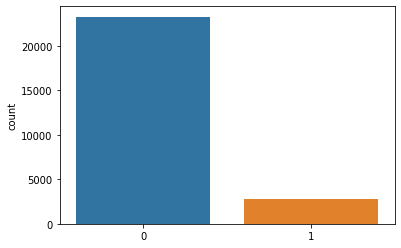

In [ ]:
# Apply logistic regression
clf = LogisticRegression(random_state=0, max_iter=200).fit(scaled_df, train_y)
pred = clf.predict(scaled_test_df)
score = clf.score(scaled_test_df,test_y)
print(score)
sns.countplot(pred)


In [ ]:
KNN_imputed_trainX_70 = pickle.load(open("KNN_imputed_trainX_70.pkl", "rb"))
#First standardize data
from sklearn.preprocessing import StandardScaler
KNN_imputed_trainX_70_std = StandardScaler().fit_transform(KNN_imputed_trainX_70)
KNN_imputed_trainX_70_std

array([[ 1.37032684, -0.01512837,  0.91849781, ..., -0.19470921,
        -0.27325846, -0.11922881],
       [ 0.12313677, -0.01512837,  0.91849781, ..., -1.36240116,
        -0.92776725,  0.66846987],
       [-1.67376077, -0.01512837,  0.91849781, ..., -0.15937437,
        -0.16349885,  0.48669325],
       ...,
       [-0.06570359, -0.01512837,  0.91849781, ..., -0.59628217,
        -0.2320656 ,  1.51676075],
       [-0.20337277,  0.92195744,  0.91849781, ...,  0.0360447 ,
         0.53712483,  0.06254781],
       [ 0.23534825, -0.01512837,  0.91849781, ..., -1.25788967,
        -0.74292749,  0.30491663]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score
RF_Cl=RandomForestClassifier(n_estimators=100)
start = time.time()
RF_Cl.fit(KNN_imputed_trainX_70_std,train_y) #training
end = time.time()
print("Time taken to train data with RFC in seconds :",end-start)

Time taken to train data with RFC in seconds : 98.20412540435791


In [ ]:
print(RF_Cl.feature_importances_)

[0.02102815 0.00311064 0.00106905 0.00806101 0.0034248  0.00217558
 0.00985738 0.01816764 0.00760799 0.00855564 0.00070927 0.00309474
 0.00819647 0.0099685  0.01074835 0.00262141 0.00293977 0.00031372
 0.00312877 0.05482908 0.00918677 0.00838162 0.00117331 0.0074622
 0.00772422 0.0069182  0.00728852 0.00984495 0.00229181 0.00897409
 0.00756142 0.00697131 0.00766142 0.00688964 0.00909299 0.00799197
 0.00711997 0.00663007 0.00689216 0.00694802 0.00734859 0.00685563
 0.00247264 0.00660855 0.0084084  0.00791768 0.00814639 0.0077602
 0.00743994 0.00692939 0.00739134 0.00718581 0.00728666 0.00732598
 0.0084052  0.00835667 0.00682875 0.00667425 0.00681451 0.00678688
 0.00741793 0.00744448 0.00424026 0.00567132 0.00786105 0.00753562
 0.00795297 0.00779349 0.00737521 0.00730107 0.00748449 0.00748601
 0.00792773 0.00782025 0.01031498 0.0098213  0.00762145 0.00858517
 0.01214032 0.01100795 0.07987438 0.0186432  0.00717041 0.00916295
 0.00910058 0.00825506 0.00883827 0.00834037 0.00737679 0.007412

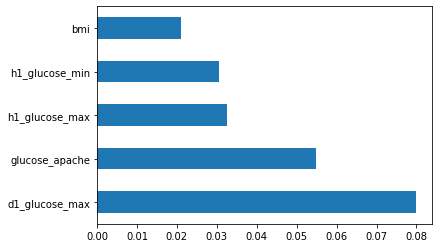

In [ ]:
(pd.Series(RF_Cl.feature_importances_, index=KNN_imputed_trainX_70.columns)
   .nlargest(5)
   .plot(kind='barh'))

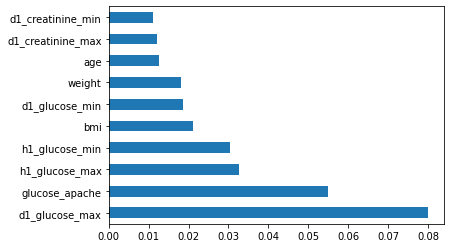

In [ ]:
(pd.Series(RF_Cl.feature_importances_, index=KNN_imputed_trainX_70.columns)
   .nlargest(10)
   .plot(kind='barh'))